In [1]:
from experiments.experiments import train, evaluate
from experiments.utils import *
from agent.agents import *
from agent.switching_agents import *
from environments.env import * 
from definitions import ROOT_DIR

from torch.optim import *
import numpy as np
import random 
import torch
import pickle
from copy import deepcopy


np.random.seed(12345678)
random.seed(12345678)
torch.manual_seed(12345678)


## Train baselines and 2-stage algorithm

### Configure Environment

In [2]:
env_generator = Environment()
width = 3
height = 20
depth = height//3
init_traffic_level = 'light'
env_params = {'width' : width, 'height':height, 'init_traffic_level': init_traffic_level, 'depth': depth}
env_generator_fn = lambda:env_generator.generate_grid_world(**env_params)
n_actions = 3

### Configure Agents

In [3]:
# Human 
estimation_noise = 2.0
switching_noise = 2.0
c_H = 0.0

# Machine

# state size with string features
n_state_features_strings = env_generator.n_state_strings(depth, width)

# define state size in 1-hot encoding
n_state_features_1hot =  env_generator.n_state_one_hot(depth, width)

n_state_features = (n_state_features_strings, n_state_features_1hot)

c_M = 0.2
lr = 1e-4
optimizer_fn = lambda params: RMSprop(params, lr)

# Switching Agent
epsilon = 0.1

### Initialize Agents

In [4]:
human  = NoisyDriverAgent(env_generator, noise_sd=estimation_noise, noise_sw=switching_noise, c_H=c_H)

machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M)

machine_only = FixedSwitchingMachine(n_state_features, optimizer_fn, c_M=c_M)

human_only = FixedSwitchingHuman()

switch_fixed_policies = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps=epsilon)

# same initialisation
switch_full = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps=epsilon)
# must be deepcopy of machine before training
switch_machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M)


### Train Steps

In [5]:
n_traj = 0
n_episodes = 2000

### Gather human traces

In [6]:
%%time
# gather human trajectories
trajectories = gather_human_trajectories(human, env_generator, n_traj,**env_params)
# save for later
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}', 'wb') as file:
    pickle.dump(trajectories, file, pickle.HIGHEST_PROTOCOL)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent', 'wb') as file:
    pickle.dump(human, file, pickle.HIGHEST_PROTOCOL)
    

Wall time: 8 ms


In [9]:

with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}', 'rb') as file:
    trajectories = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent', 'rb') as file:
    human = pickle.load(file)

### Evaluation Parametes

In [6]:
n_eval_set_size = 1000
eval_freq = 500
save_freq = 10000
eval_set = [ env_generator_fn() for i in range(n_eval_set_size)]

### Training

In [7]:

machine_only_algo = {'pre_trained_machine': (machine_only, [human, machine])}
machine_only_algo, machine_only_costs = train(machine_only_algo, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)

2021-05-22 16:55:20.055183, On-policy, Episode 500, pre_trained_machine  evaluation cost: 38.722
2021-05-22 16:57:46.486558, On-policy, Episode 1000, pre_trained_machine  evaluation cost: 38.846
2021-05-22 17:00:17.028168, On-policy, Episode 1500, pre_trained_machine  evaluation cost: 38.662
2021-05-22 17:02:50.024919, On-policy, Episode 2000, pre_trained_machine  evaluation cost: 38.376


In [12]:
evaluate(machine_only,[human, machine],eval_set )

-49.96500000000001

In [9]:
%%time 
machine_only_algo, machine_only_costs = train(machine_only_algo, trajectories, env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)

2021-05-20 15:21:30.922754, On-policy, Episode 1000, pre_trained_machine  evaluation cost: 38.038
2021-05-20 15:23:42.769296, On-policy, Episode 2000, pre_trained_machine  evaluation cost: 37.848
2021-05-20 15:25:55.813905, On-policy, Episode 3000, pre_trained_machine  evaluation cost: 38.12
2021-05-20 15:28:08.778510, On-policy, Episode 4000, pre_trained_machine  evaluation cost: 38.686
Wall time: 11min 10s


In [8]:
%%time

machine.trainable = False
algos = {'fixed_policies': (switch_fixed_policies,[human, machine]), 'switching':( switch_full,[human, switch_machine]) }

algos, algos_costs = train(algos, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)


2021-05-22 18:36:47.402359, On-policy, Episode 500, fixed_policies  evaluation cost: 11.905199999999999
2021-05-22 18:37:39.805356, On-policy, Episode 500, switching  evaluation cost: 11.880799999999999
2021-05-22 18:42:12.309943, On-policy, Episode 1000, fixed_policies  evaluation cost: 12.016
2021-05-22 18:43:01.093733, On-policy, Episode 1000, switching  evaluation cost: 12.0198
2021-05-22 18:47:22.628692, On-policy, Episode 1500, fixed_policies  evaluation cost: 12.1558
2021-05-22 18:48:07.135237, On-policy, Episode 1500, switching  evaluation cost: 12.044799999999999
2021-05-22 18:52:03.583761, On-policy, Episode 2000, fixed_policies  evaluation cost: 12.0002
2021-05-22 18:52:48.055305, On-policy, Episode 2000, switching  evaluation cost: 11.688799999999999
Wall time: 19min 45s


## Evaluate Performance

In [18]:
# human_cost = evaluate(human_only, [human], eval_set)
# full_offline = algos_costs['switching'][n_traj - 1 ]
# algos_costs ={**algos_costs, **machine_only_costs}
# switch_costs = { alg: algos_costs[alg][(n_traj - 1):] for alg in algos_costs}
costs = {'human_only': [human_cost]*n_episodes, **switch_costs}


In [25]:
costs ={ k: algos_costs[k] for k in algos_costs}
costs = {**costs, 'human': [human_cost]*4}
costs.

{'fixed_policies': [11.905199999999999, 12.016, 12.1558, 12.0002],
 'switching': [11.880799999999999,
  12.0198,
  12.044799999999999,
  11.688799999999999],
 'pre_trained_machine': [38.722, 38.846, 38.662, 38.376],
 'human': [10.538, 10.538, 10.538, 10.538]}

<AxesSubplot:>

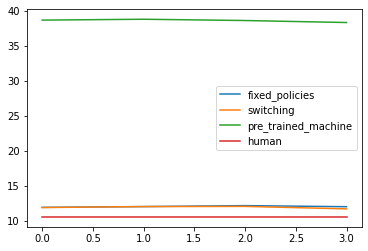

In [26]:
import pandas as pd

df = pd.DataFrame(costs)
df.plot()


# Playground

In [4]:
 on_off = 'off'
 name = 'pre_trained_machine'
 with open(f'{ROOT_DIR}/outputs/agents/{name}/costs_'+on_off, 'rb') as file:
    costs = pickle.load(file)

costs

[35.658,
 23.038,
 22.272,
 31.012000000000004,
 19.382,
 17.158,
 36.63,
 18.792,
 29.298000000000005,
 37.56]

In [3]:
%%time
fully_automated, [human, machine] , fully_automated_costs = run_pre_train_machine(fully_automated, [human, machine], trajectories, env_generator_fn, n_episodes)

2021-05-17 20:45:13.320152, Episode 1000, Fully automated on-policy algorithm cumulative cost: 35535.8
2021-05-17 20:47:13.406020, Episode 2000, Fully automated on-policy algorithm cumulative cost: 72123.8
2021-05-17 20:49:16.207044, Episode 3000, Fully automated on-policy algorithm cumulative cost: 109591.80000000002
2021-05-17 20:51:19.102073, Episode 4000, Fully automated on-policy algorithm cumulative cost: 147059.8
Wall time: 29min 1s


In [23]:
from plot.plot_path import PlotPath
from experiments.utils import *
gird_world = env_generator_fn()
plt_path = PlotPath(gird_world, n_try=1)
plt_path1 = PlotPath(gird_world, n_try=1)



cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
is_learn=False, plt_path = plt_path, machine_only=True)

cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world ,
is_learn=False, plt_path = plt_path1)

plt_path.plot('../machine_only_light.png')
plt_path1.plot('../machine_dummy_only_light.png')

print(cost, cost1)

39.8 57.8


In [22]:
res = []
for _ in range(10):
    is_better = 0
    for i in range(100):
        gird_world = env_generator_fn()
        cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
        is_learn=False, plt_path = plt_path, machine_only=True)

        cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world , 
        is_learn=False, plt_path = plt_path1)

        is_better+= (cost1 >= cost)

    print(is_better/100)
    res.append(is_better/100)
    print(cost, cost1)
print(np.mean(res))

0.51
27.799999999999997 35.800000000000004
0.59
17.799999999999997 19.799999999999994
0.45
27.79999999999999 31.799999999999994
0.46
39.80000000000002 41.800000000000004
0.57
35.8 17.799999999999997
0.46
61.800000000000026 63.80000000000001
0.47
21.799999999999997 41.8
0.39
21.79999999999999 15.799999999999997
0.54
41.8 47.8
0.55
9.799999999999999 21.799999999999994
0.499


10000 off 15000 on
0.56
0.46
0.47
0.55
0.52
0.55
0.51
0.44
0.57
0.6
0.523

In [8]:
from copy import deepcopy
import torch
a = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=0.2)
b = deepcopy(a)
torch.all(list(switch_machine.network.parameters())[0] == list(machine.network.parameters())[0])

tensor(False)

In [24]:
(list(machine.network.parameters())[3]).grad

tensor([4.2675e-14, 0.0000e+00, 2.3021e-14])

In [21]:
list(switch_machine.network.parameters())[3],list(machine.network.parameters())[3].grad

(Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 tensor([-7.8448e-18,  0.0000e+00,  1.1218e-24]))